In [234]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
import time
import os
from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized,
    EnsureChannelFirst,
    DivisiblePad,
    NormalizeIntensity
)

from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np
print(monai.__version__) 
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch

0.8.0
MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



##  Data location

In [235]:
lieu = 'jony_laptop' # 
if lieu =='sebastian_laptop': # jony_laptop
    isles_data_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/'
    isles_data_val_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/VALIDATION/'


if lieu =='jony_laptop': # jony_laptop
    isles_data_root = '/home/diffusion/Desktop/ISLES2018_Training/TRAINING/'
    isles_data_val_root = '/home/diffusion/Desktop/ISLES2018_Val/'


## Only cerebral blood flow is being used

In [236]:
cbf_paths = sorted(glob(isles_data_root+'*/*CBF*/*nii'))
cbv_paths = sorted(glob(isles_data_root+'*/*CBV*/*nii'))
mtt_paths = sorted(glob(isles_data_root+'*/*MTT*/*nii'))
tmx_paths = sorted(glob(isles_data_root+'*/*Tmax*/*nii'))
lbl_paths = sorted(glob(isles_data_root+'*/*OT*/*nii'))
print(cbf_paths[-1])

/home/diffusion/Desktop/ISLES2018_Training/TRAINING/case_94/SMIR.Brain.XX.O.CT_CBF.346202/SMIR.Brain.XX.O.CT_CBF.346202.nii


In [237]:
cbf_paths_val = sorted(glob(isles_data_val_root+'*/*CBF*/*nii'))
cbv_paths_val = sorted(glob(isles_data_val_root+'*/*CBV*/*nii'))
mtt_paths_val = sorted(glob(isles_data_val_root+'*/*MTT*/*nii'))
tmx_paths_val = sorted(glob(isles_data_val_root+'*/*Tmax*/*nii'))
lbl_paths_val = sorted(glob(isles_data_val_root+'*/*OT*/*nii'))
print(cbf_paths_val[-1])

/home/diffusion/Desktop/ISLES2018_Val/case_94/SMIR.Brain.XX.O.CT_CBF.346202/SMIR.Brain.XX.O.CT_CBF.346202.nii


### Training augmentation and normalization

In [191]:
imtrans = Compose(
    [   LoadImage(image_only=True),
        NormalizeIntensity(),
        DivisiblePad(4),
        AddChannel(),
        RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),        
        DivisiblePad(4),
        AddChannel(),
        RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)


val_imtrans  = Compose(
    [   LoadImage(image_only=True),
        NormalizeIntensity(),
        DivisiblePad(4),
        AddChannel(),
        #RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)
#val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), EnsureType()])

val_segtrans = Compose(
    [   LoadImage(image_only=True),
        DivisiblePad(4),
        AddChannel(),
       # RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ])


In [192]:
# imtrans = Compose(
#     [   LoadImage(image_only=True),
#         ScaleIntensity(),
#         DivisiblePad(4),
#         AddChannel(),
#         RandSpatialCrop((256, 256,4), random_size=False),
#         EnsureType(),
#         #Resized
#     ]
# )

# segtrans = Compose(
#     [   LoadImage(image_only=True),
#         DivisiblePad(4),
#         AddChannel(),
#         RandSpatialCrop((256, 256,4), random_size=False),
#         EnsureType(),
#         #Resized
#     ]
# )


# val_imtrans  = Compose(
#     [   LoadImage(image_only=True),
#         ScaleIntensity(),
#         DivisiblePad(4),
#         AddChannel(),
#         #RandSpatialCrop((256, 256,4), random_size=False),
#         EnsureType(),
#         #Resized
#     ]
# )
# #val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), EnsureType()])

# val_segtrans = Compose(
#     [   LoadImage(image_only=True),
#         DivisiblePad(4),
#         AddChannel(),
#        # RandSpatialCrop((256, 256,4), random_size=False),
#         EnsureType(),
#         #Resized
#     ])


## Image read (to change to files)

In [195]:
ds      = ArrayDataset(cbf_paths, imtrans, lbl_paths, segtrans)

val_ds  = ArrayDataset(cbf_paths_val, val_imtrans, lbl_paths_val, val_segtrans)

AttributeError: 'tuple' object has no attribute 'shape'

In [194]:
print(len(set(cbf_paths)), len(set(cbf_paths_val)))

94 14


In [159]:
loader = torch.utils.data.DataLoader( ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([1, 1, 256, 256, 4]) torch.Size([1, 1, 256, 256, 4])


In [160]:
# create a validation data loader
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

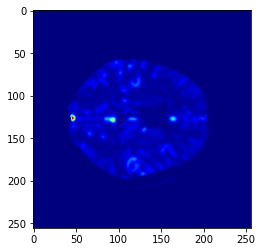

In [161]:
sample_im, sample_seg = im.numpy(), seg.numpy()
plt.imshow(sample_im[0,0,:,:,3],cmap='jet')

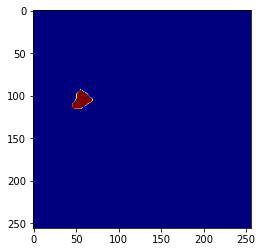

In [162]:
plt.imshow(sample_seg[0,0,:,:,3],cmap='jet')

In [214]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

In [215]:
#post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [216]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [217]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 1),
    #kernel_size = (3,3,2),
    #dropout = 0.2,
    num_res_units=2,
).to(device)

# model = monai.networks.nets.UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128),
#     strides=(2, 2, 2),
#     kernel_size = (3,3,3),
#     #dropout = 0.2,
#     num_res_units=2,
# ).to(device)

In [218]:
loss_function = monai.losses.DiceLoss(sigmoid=True)

#optimizer = torch.optim.Adam(model.parameters(), 1e-3)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [219]:
batch_data = next(iter(loader))
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
print(batch_data[0][0].shape)
print(inputs.shape)

torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])


In [220]:
print(inputs.shape,labels.shape)

torch.Size([1, 4, 256, 256]) torch.Size([1, 4, 256, 256])


In [221]:
#inputs[np.newaxis,:,:].shape

In [222]:
model(inputs[np.newaxis,:,:,:,:]).shape

torch.Size([1, 1, 4, 256, 256])

In [223]:
model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [224]:
optimizer.zero_grad()

In [225]:
outputs = model(inputs[np.newaxis,:,:,:,:,])

In [226]:
loss = loss_function(outputs, labels[np.newaxis,:,:,:,:])

In [227]:
loss.backward()

In [228]:
optimizer.step()

torch.Size([1, 1, 256, 256, 4])
10


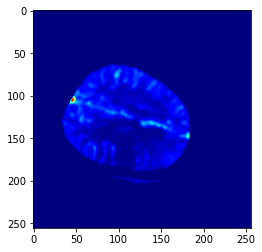

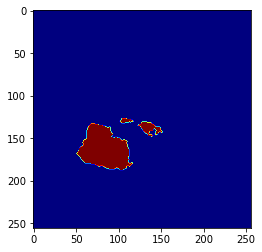

In [229]:
for i,batch_data in enumerate(loader):
    if(i==10):
        plt.figure()
        plt.imshow(batch_data[0][0,0,:,:,2],cmap='jet')
        plt.figure()
        plt.imshow(batch_data[1][0,0,:,:,2],cmap='jet')
        print(batch_data[1].shape)
        print(i)

In [243]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )


    return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = False


epochs = 150
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
best_metrics_epochs_and_time = [[], [], []]
total_start = time.time()
for epoch in range(epochs):
    
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
   
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in loader:
        
        step += 1
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)

        print(batch_data[0][0].shape)
        print(inputs.shape)
        
        optimizer.zero_grad()
        
        #outputs = model(inputs[np.newaxis,:,:,:,:])
        outputs = model(inputs[np.newaxis,:,:,:,:,])
        
        loss = loss_function(outputs, labels[np.newaxis,:,:,:,:])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(loader) // loader.batch_size
        
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch ) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
#             metric_values_tc.append(metric_tc)
#             metric_wt = metric_batch[1].item()
#             metric_values_wt.append(metric_wt)
#             metric_et = metric_batch[2].item()
#             metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

total_time = time.time() - total_start

----------
epoch 1/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.9680
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.5448
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.9474
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.7978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.8981
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.9034
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.7815
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.5393
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.8622
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9646
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.7583
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94

2/94, train_loss: 0.5037
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.9446
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.7712
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.8868
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.8984
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.7649
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.5384
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.8443
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9521
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.7462
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.9808
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.7214
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])


6/94, train_loss: 0.8733
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.7086
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.5395
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.8281
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9391
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.7118
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.9574
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.7400
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9861
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 0.9983
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.9454
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.8299
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 25

9/94, train_loss: 0.8053
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9312
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.6696
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.9621
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.6976
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9870
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 0.9987
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.9464
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.8088
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.6453
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 0.9996
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.6625
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256,

13/94, train_loss: 0.6820
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9846
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 0.9968
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.9355
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.7766
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.6288
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 0.9998
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.5232
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.5714
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.3513
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.8785
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3981
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

16/94, train_loss: 0.9411
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.8135
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.6844
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 0.9992
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.6871
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.4987
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.3534
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.8883
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3633
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.7397
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3655
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.6802
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

20/94, train_loss: 0.5386
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.4649
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2654
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.8353
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.6284
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3495
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.6192
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.8820
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.8397
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.5031
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.4740
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

23/94, train_loss: 0.8650
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3266
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.6238
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3544
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.6418
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.8009
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.8300
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.5024
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.5142
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9656
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.8476
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.8262
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

27/94, train_loss: 0.5895
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.8104
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.8137
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.4999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.5211
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9669
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.8533
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.8299
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.8175
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.8873
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.6156
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.4545
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

30/94, train_loss: 0.4842
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.5378
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9745
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.8842
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.8146
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.8055
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.9915
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.6056
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.4474
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.4084
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.8498
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.8216
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

34/94, train_loss: 0.7819
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.7622
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.9856
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.5406
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.4984
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.4301
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.8472
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.7907
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.3992
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.5013
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9593
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.4134
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

37/94, train_loss: 0.5616
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.4850
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.4026
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.8717
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.8122
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.4315
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.4755
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9588
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.3495
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.9387
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.9979
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.9188
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

41/94, train_loss: 0.7502
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.3768
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.4368
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9417
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.3631
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.8996
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.9833
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.9081
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.9192
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.8956
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.7081
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

44/94, train_loss: 0.9230
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.4695
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.8911
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.9736
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.8750
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.9107
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.9085
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.4108
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.2536
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.3763
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.6748
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

48/94, train_loss: 0.8825
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.8957
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.8836
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.5450
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.2285
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.3095
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.5685
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.3793
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2270
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.5291
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.4928
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.3864
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.4297
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.6057
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.4674
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2420
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.3537
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.8279
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.4377
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.7085
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

56/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.3441
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2619
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.5442
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.5711
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.7055
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.4873
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6631
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3760
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.2182
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

59/94, train_loss: 0.6116
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.5913
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.4099
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.6993
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.3977
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6874
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.4772
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.4131
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.3708
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.2990
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.3402
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

63/94, train_loss: 0.4427
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.7130
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3970
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.3001
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.4015
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.3173
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.3965
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.4960
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.7372
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2809
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2528
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

66/94, train_loss: 0.3850
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.2851
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.2831
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.3198
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.3480
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6346
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2179
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2537
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.2521
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.3502
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.8323
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

70/94, train_loss: 0.3416
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.3454
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6773
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2757
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2460
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.2674
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.2633
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.8155
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.6602
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

73/94, train_loss: 0.2153
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2560
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.2465
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.3143
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.8159
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.6354
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2933
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.4210
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.4935
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

77/94, train_loss: 0.8604
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.6680
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3352
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.4027
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.4881
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.5472
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

80/94, train_loss: 0.6449
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3452
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.3879
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.4860
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.5470
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.9015
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.9115
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

84/94, train_loss: 0.5033
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.5144
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.8782
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.9047
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 1.0000
epoch 25 average loss: 0.6127
current epoch: 25 current mean dice: 0.0036 best mean dice: 0.0427 at epoch 1
----------
epoch 26/10
tor

87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.8911
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.7982
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 1.0000
epoch 26 average loss: 0.6385
----------
epoch 27/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.8238
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.5424
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.8157
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.4410
t

91/94, train_loss: 0.8468
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 1.0000
epoch 27 average loss: 0.6344
current epoch: 27 current mean dice: 0.0133 best mean dice: 0.0427 at epoch 1
----------
epoch 28/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.8849
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.5325
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.8498
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.4672
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.5915
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.5490
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.5854
torch.Size

94/94, train_loss: 1.0000
epoch 28 average loss: 0.6252
----------
epoch 29/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.9423
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.5725
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.7741
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.4698
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.5188
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.4537
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.5884
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.6618
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.5507
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.8113
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3598
torch.

2/94, train_loss: 0.5731
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.7083
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.4834
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.4934
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.4745
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.5841
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.6651
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.5843
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.7085
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2990
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.5725
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4913
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])


6/94, train_loss: 0.3939
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.5778
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.7505
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.5345
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.6742
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3128
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.5453
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.5366
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9878
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.9233
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6411
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 25

9/94, train_loss: 0.5532
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.6663
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3199
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.4241
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4964
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9568
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.8809
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6284
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.2891
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.5477
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256,

13/94, train_loss: 0.4946
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9833
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.9789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6450
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.4512
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.5840
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.5591
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.4368
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.7799
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

16/94, train_loss: 0.9747
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6318
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.3924
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.4762
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.4633
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.3435
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.7487
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3849
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.5017
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.4927
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.4248
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

20/94, train_loss: 0.4519
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.4222
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.3152
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.7839
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.4002
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.4961
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.4311
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.3842
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.6113
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.6586
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2508
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1926
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

23/94, train_loss: 0.8316
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.3803
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.4666
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.4543
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.6135
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5932
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.6450
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.3210
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.2103
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9388
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.7776
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.5256
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

27/94, train_loss: 0.4298
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.6636
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.6147
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2895
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.2098
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9150
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.7640
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.5080
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.5584
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.7879
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.3475
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1799
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

30/94, train_loss: 0.2013
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.2257
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9215
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.6609
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.4373
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.4989
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.8498
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.3363
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1742
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0756
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.7516
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.6457
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

34/94, train_loss: 0.5180
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.5470
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.8007
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.3217
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1706
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0816
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.7780
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.6474
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0998
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2610
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9344
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.4819
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

37/94, train_loss: 0.3557
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1608
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0652
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.7600
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.7082
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.1189
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2527
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9240
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.4706
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.8040
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.9880
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.7647
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

41/94, train_loss: 0.6837
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0992
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2887
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9400
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.5031
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.7053
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.7336
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.8237
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.8243
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.2254
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

44/94, train_loss: 0.9253
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.5356
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.7944
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.7463
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.8554
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.8165
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.4448
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1569
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2715
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1984
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

48/94, train_loss: 0.7724
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.8656
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.8337
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.2580
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1610
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2630
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.2148
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2886
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2357
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1761
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.2236
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1198
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.3006
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1711
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2758
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.3186
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.2726
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.3972
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.4757
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

55/94, train_loss: 0.2833
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.3389
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2342
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.5264
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.5779
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.4074
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.6732
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2880
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6563
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.4001
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.2005
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

58/94, train_loss: 0.1628
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2246
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.3994
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.3396
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.5683
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.3750
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.5546
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1532
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1163
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1442
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

62/94, train_loss: 0.5471
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.4134
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6673
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.4671
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.4723
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.3334
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.2980
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.3443
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.3480
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.7232
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2501
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

65/94, train_loss: 0.3226
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1809
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1338
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1334
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2619
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2570
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6586
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2135
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2548
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.2040
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1663
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

69/94, train_loss: 0.1270
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2426
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2453
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6090
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1762
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2429
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1730
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1422
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.6618
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.4905
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

72/94, train_loss: 0.5987
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2011
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2383
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1567
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.6136
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.4896
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3195
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2848
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

76/94, train_loss: 0.1411
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.5692
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.4614
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3474
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2604
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2425
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.4327
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.4365
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3499
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2558
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2634
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.4364
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.6494
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

83/94, train_loss: 0.2177
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2672
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.4410
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.6715
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.5745
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.9998
epoch 53 average loss: 0.4984
current epoch: 53 cu

86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.7882
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.5751
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 1.0000
epoch 54 average loss: 0.5160
----------
epoch 55/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.7289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.3331
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.5857


90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.5493
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.9999
epoch 55 average loss: 0.5033
current epoch: 55 current mean dice: 0.0035 best mean dice: 0.0427 at epoch 1
----------
epoch 56/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.3477
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.3059
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.4527
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.2375
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.3059
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.3894
torch.Siz

93/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 1.0000
epoch 56 average loss: 0.4908
----------
epoch 57/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.2789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2902
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.4204
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.2022
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.3070
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.3740
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.3146
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4484
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3874
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.4245
torch.

1/94, train_loss: 0.3283
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2946
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.4159
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1734
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.2897
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.3387
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.3201
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3755
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3608
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.5516
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2811
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.4320
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1

5/94, train_loss: 0.4365
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.4226
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.3081
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4096
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.4009
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.4741
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3132
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.7581
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.7284
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.8297
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256

8/94, train_loss: 0.4351
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3704
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.4408
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2982
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.4457
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4853
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9996
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.8278
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6248
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.2457
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 

12/94, train_loss: 0.3069
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4821
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.8117
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6190
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.2971
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2516
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.2409
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2750
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.6413
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.8117
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.6318
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.2238
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2522
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.2519
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2447
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.6088
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.2007
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3690
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.2858
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2189
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.2151
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2373
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.5982
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1870
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3776
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.2535
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.4030
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5376
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.4058
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.3096
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

22/94, train_loss: 0.2529
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.6600
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1844
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3779
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3075
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.3896
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5864
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.4799
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2668
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.2825
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9104
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.6327
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

26/94, train_loss: 0.3307
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.3640
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.6266
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.5204
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2162
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.2779
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9129
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.6358
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.3455
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.2174
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.4876
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.3181
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

29/94, train_loss: 0.5434
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2461
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1821
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9245
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.6583
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.3212
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.2885
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.4714
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2899
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1549
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0926
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.6758
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

33/94, train_loss: 0.5574
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.2719
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.2499
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.4157
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2866
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1600
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0975
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.6860
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.4938
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0934
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2456
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.8959
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

36/94, train_loss: 0.5254
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2821
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1579
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0908
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.6793
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.4599
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.1191
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2750
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.7879
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2600
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.4592
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.5820
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

40/94, train_loss: 0.6662
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.4482
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.1151
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2497
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.7782
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2441
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.4243
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.8052
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.6021
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7904
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.6771
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

43/94, train_loss: 0.2414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.8085
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2516
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.4352
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.6738
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.5742
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7983
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.6050
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1825
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.2510
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.3403
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

47/94, train_loss: 0.6631
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.5603
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7381
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.4311
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.6620
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.5445
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.5127
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.2732
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2341
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2440
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

50/94, train_loss: 0.6232
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.3072
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.3662
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.3654
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.2804
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.3892
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2732
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.8969
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.2401
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.3028
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

54/94, train_loss: 0.2543
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1907
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2554
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1649
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1962
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.2083
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.3907
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.3503
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.3013
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6835
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.4644
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

57/94, train_loss: 0.4084
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2506
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.4050
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.6082
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2802
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.6250
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.3199
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.5993
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3839
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1825
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1676
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

61/94, train_loss: 0.3876
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.3698
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.3020
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.6032
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3594
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1582
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1542
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1287
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2684
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6011
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

64/94, train_loss: 0.4209
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3385
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1665
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1208
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1198
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2591
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2665
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.5754
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1411
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2587
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1661
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

68/94, train_loss: 0.0869
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1084
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2201
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2558
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6478
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1249
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2633
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1901
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.6143
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

71/94, train_loss: 0.3064
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.7225
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1256
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.3033
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1397
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.2679
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.7903
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.2820
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2889
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

75/94, train_loss: 0.1447
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.2701
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.7860
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.3685
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 0.9992
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3192
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.1811
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2387
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.4149
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.4701
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2790
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2709
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.3381
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.5104
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.9880
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

82/94, train_loss: 0.3432
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2584
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2727
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.4298
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.7456
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.4330
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

85/94, train_loss: 0.4075
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.6796
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.4203
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.9999
epoch 82 average loss: 0.4903
----------
epoch 83/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.5470
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2566

89/94, train_loss: 0.6151
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.3636
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.9996
epoch 83 average loss: 0.4820
current epoch: 83 current mean dice: 0.0134 best mean dice: 0.0427 at epoch 1
----------
epoch 84/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.2444
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2433
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.3545
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.2119
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.3282
torch.Si

92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.9996
epoch 84 average loss: 0.4538
----------
epoch 85/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1915
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2506
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.3203
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.2042
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.3128
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.3254
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1705
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4067
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2563
torch.

torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.3058
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2458
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.3214
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1916
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.2767
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2981
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1329
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4043
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3121
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.4707
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3060
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1735
t

4/94, train_loss: 0.2818
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.2622
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2534
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1345
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3908
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3126
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.3926
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2711
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1992
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4281
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9989
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256]

7/94, train_loss: 0.1359
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3933
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.3089
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.3578
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2975
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.2237
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4674
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.5896
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5893
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1887
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 2

11/94, train_loss: 0.2951
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.2037
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.4509
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.7108
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5573
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1836
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2251
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.3191
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2349
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

14/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.6469
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5771
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1741
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2400
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.2455
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2725
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.3491
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1480
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.4062
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

18/94, train_loss: 0.2800
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.4060
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.3109
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.3067
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.3034
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1383
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.4250
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3057
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.3659
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5165
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2648
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

21/94, train_loss: 0.2769
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2505
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.5083
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.2011
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3668
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3146
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.4036
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5593
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.1854
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1959
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9062
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

25/94, train_loss: 0.4231
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.3426
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.3443
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.5809
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.4090
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.2617
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1567
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.9146
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.5618
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.2734
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.2580
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.3434
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

28/94, train_loss: 0.5470
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.3122
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.1976
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1504
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.8627
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.4004
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.2272
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.1722
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.2241
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2433
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1838
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

32/94, train_loss: 0.8971
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.5053
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.3700
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.3561
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.3318
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2594
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.2424
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.1010
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.4701
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.2878
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.3520
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.4279
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

35/94, train_loss: 0.1683
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.2551
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2697
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1402
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0816
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.5737
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.3590
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0788
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2219
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.6820
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2104
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.3606
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

39/94, train_loss: 0.0802
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.5630
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.3596
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0962
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2361
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.6430
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2418
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.3881
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.6803
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.6105
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7943
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.7262
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

42/94, train_loss: 0.1302
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2664
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.9914
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2314
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.7732
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.5128
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7427
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.6905
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1425
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1129
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

46/94, train_loss: 0.5310
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.7463
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.5128
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.7357
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.5822
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1491
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1126
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2543
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1362
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2464
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

49/94, train_loss: 0.7916
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.7075
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1933
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1156
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2381
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1764
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2478
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1894
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1758
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.4293
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

52/94, train_loss: 0.1284
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.0993
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2137
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1546
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.3361
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1281
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2745
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.1932
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.3277
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2529
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2665
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

55/94, train_loss: 0.1406
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2956
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1541
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2213
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.3774
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2358
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2101
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2752
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.3411
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3191
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1321
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

58/94, train_loss: 0.2038
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2303
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.1386
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2625
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2627
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2569
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.3079
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.3053
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1419
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.6568
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.0830
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1014
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

61/94, train_loss: 0.2537
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2325
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2824
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.3358
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1354
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.9999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1030
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1047
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2470
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2604
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.5751
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

64/94, train_loss: 0.2079
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2941
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1699
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.2501
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1261
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2960
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2770
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.5368
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2103
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2494
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1599
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

67/94, train_loss: 0.9588
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1288
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2532
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2449
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.5718
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1882
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2999
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1601
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1489
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.2970
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

70/94, train_loss: 0.2665
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.3187
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.6383
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2297
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2605
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1434
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.3243
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.4141
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1655
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

73/94, train_loss: 0.1471
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2937
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1229
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1422
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.3724
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.2005
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.3200
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2591
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.2133
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

76/94, train_loss: 0.2030
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.3770
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1640
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2793
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2175
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1869
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.3479
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1696
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2942
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2283
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1955
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.3427
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4919
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

82/94, train_loss: 0.2598
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2136
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1801
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.3064
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.5109
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.2558
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.9997
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

85/94, train_loss: 0.3068
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4894
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.2374
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.9717
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.1248
epoch 112 average loss: 0.3739
----------
epoch 113/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1670
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.23

88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4789
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.2272
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.9618
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.1412
epoch 113 average loss: 0.3724
current epoch: 113 current mean dice: 0.0109 best mean dice: 0.0427 at epoch 1
----------
epoch 114/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1607
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2230
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.2112
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1804
torc

91/94, train_loss: 0.2932
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.9460
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.1592
epoch 114 average loss: 0.4025
----------
epoch 115/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1689
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2383
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.2471
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1970
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.2193
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2226
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1282
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3993
tor

94/94, train_loss: 0.1761
epoch 115 average loss: 0.4343
current epoch: 115 current mean dice: 0.0154 best mean dice: 0.0427 at epoch 1
----------
epoch 116/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.2607
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2771
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.2445
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1688
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1948
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.1990
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1813
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4108
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2602
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.3803
torch.Siz

2/94, train_loss: 0.2344
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.2137
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1975
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1358
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2178
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1169
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3842
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2430
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.3964
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2366
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1686
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.3493
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])


5/94, train_loss: 0.3243
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2132
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1602
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.4345
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2929
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.4629
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.3067
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1710
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.3502
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9738
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.4653
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256

9/94, train_loss: 0.2869
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.3654
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2543
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1851
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.3116
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9785
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.5382
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5566
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1958
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2189
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256,

12/94, train_loss: 0.2023
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.3133
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.9974
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.4768
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5835
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1563
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2028
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.1845
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2140
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.1855
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
16/94, train_loss: 0.4809
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
17/94, train_loss: 0.5217
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
18/94, train_loss: 0.1524
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2074
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.1686
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2122
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.1964
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1167
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3180
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.2161
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

18/94, train_loss: 0.1612
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
19/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
20/94, train_loss: 0.2025
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
21/94, train_loss: 0.1517
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2150
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.2033
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1380
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3482
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.1959
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.2663
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.4378
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2039
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

21/94, train_loss: 0.2345
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
22/94, train_loss: 0.2252
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
23/94, train_loss: 0.2534
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
24/94, train_loss: 0.1325
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3798
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.2548
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.2987
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.4669
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2136
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.1785
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1383
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.8257
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

24/94, train_loss: 0.1447
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
25/94, train_loss: 0.3313
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
26/94, train_loss: 0.2505
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
27/94, train_loss: 0.2982
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.4814
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2443
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.1921
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1522
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.8599
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.3450
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.1761
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.1823
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

27/94, train_loss: 0.2933
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
28/94, train_loss: 0.4030
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
29/94, train_loss: 0.2167
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
30/94, train_loss: 0.1893
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.7921
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.2968
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.2981
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.1666
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.1775
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2206
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1526
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

30/94, train_loss: 0.1667
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
31/94, train_loss: 0.1159
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
32/94, train_loss: 0.8338
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
33/94, train_loss: 0.3233
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.2303
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.1426
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.1678
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2262
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1604
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0760
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.3362
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.1982
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

33/94, train_loss: 0.3031
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
34/94, train_loss: 0.1708
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
35/94, train_loss: 0.1413
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
36/94, train_loss: 0.2525
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2468
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1281
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0764
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.4074
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.2808
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0806
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.1606
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.6132
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

36/94, train_loss: 0.2656
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
37/94, train_loss: 0.2535
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
38/94, train_loss: 0.1289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
39/94, train_loss: 0.0679
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.3943
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.2330
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0986
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.1582
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.5188
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.1764
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.3241
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.3580
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

39/94, train_loss: 0.0667
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
40/94, train_loss: 0.3632
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
41/94, train_loss: 0.2173
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
42/94, train_loss: 0.0925
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.1542
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.4730
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2015
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.2859
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.4289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.4456
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.6657
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.4430
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

42/94, train_loss: 0.1287
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
43/94, train_loss: 0.2148
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
44/94, train_loss: 0.4988
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
45/94, train_loss: 0.2886
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.4145
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.8649
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.5508
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.6765
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.5466
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1315
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.0842
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

45/94, train_loss: 0.2079
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
46/94, train_loss: 0.3643
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
47/94, train_loss: 0.6558
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
48/94, train_loss: 0.4104
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.5773
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.2956
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1434
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1102
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.1978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1542
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

48/94, train_loss: 0.4822
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
49/94, train_loss: 0.5998
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
50/94, train_loss: 0.1369
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1568
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1055
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.1907
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1277
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.2062
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1573
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1441
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

51/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
52/94, train_loss: 0.1343
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
53/94, train_loss: 0.1156
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
54/94, train_loss: 0.2089
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1310
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.1678
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.2612
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.2255
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.2077
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2472
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2659
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

54/94, train_loss: 0.1971
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
55/94, train_loss: 0.1038
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
56/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
57/94, train_loss: 0.1344
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1873
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1417
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.0772
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2439
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.1972
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2154
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.1934
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2408
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

57/94, train_loss: 0.2043
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
58/94, train_loss: 0.1190
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
59/94, train_loss: 0.1640
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
60/94, train_loss: 0.1448
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2978
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.3126
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2503
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.3419
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2524
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1427
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.7047
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1065
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

60/94, train_loss: 0.1031
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
61/94, train_loss: 0.2363
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
62/94, train_loss: 0.2301
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
63/94, train_loss: 0.2347
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.1959
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2567
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1228
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.5245
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.0990
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.0950
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2299
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

63/94, train_loss: 0.2434
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
64/94, train_loss: 0.2459
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
65/94, train_loss: 0.2386
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
66/94, train_loss: 0.1624
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.4570
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1688
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.1011
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2255
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2311
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.5565
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.2691
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.3163
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

66/94, train_loss: 0.1416
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
67/94, train_loss: 0.5051
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
68/94, train_loss: 0.1019
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
69/94, train_loss: 0.0954
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2236
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.2059
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.4955
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1576
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2205
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1480
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1256
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.2479
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

69/94, train_loss: 0.0896
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
70/94, train_loss: 0.2263
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
71/94, train_loss: 0.1909
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
72/94, train_loss: 0.4863
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1254
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2078
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1522
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1390
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.2724
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1421
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

72/94, train_loss: 0.5452
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
73/94, train_loss: 0.1894
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
74/94, train_loss: 0.2298
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
75/94, train_loss: 0.1552
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1332
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.2313
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1808
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2091
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.1894
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

75/94, train_loss: 0.1414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
76/94, train_loss: 0.1388
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
77/94, train_loss: 0.2516
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.1414
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2184
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2139
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1392
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.2413
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

78/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
79/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
80/94, train_loss: 0.2393
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2645
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2197
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1480
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.2779
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4299
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

81/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
82/94, train_loss: 0.2445
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
83/94, train_loss: 0.2201
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
84/94, train_loss: 0.1674
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.2696
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4352
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.1781
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256

84/94, train_loss: 0.1392
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
85/94, train_loss: 0.2544
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
86/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.4080
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.2460
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.5161
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.1179
epoch 144 average loss: 0.3276
----------
epoch 145/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1

87/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
88/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
89/94, train_loss: 0.3860
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.1924
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.5399
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.0911
epoch 145 average loss: 0.3218
current epoch: 145 current mean dice: 0.0086 best mean dice: 0.0427 at epoch 1
----------
epoch 146/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1940
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2200
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.1700
tor

90/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
91/94, train_loss: 0.1733
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
92/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
93/94, train_loss: 0.5079
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.0869
epoch 146 average loss: 0.3192
----------
epoch 147/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1429
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2223
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.1821
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1524
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1231
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.1700
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.0768
to

93/94, train_loss: 0.5056
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
94/94, train_loss: 0.1489
epoch 147 average loss: 0.3325
current epoch: 147 current mean dice: 0.0147 best mean dice: 0.0427 at epoch 1
----------
epoch 148/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.1410
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2153
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.1608
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1951
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1535
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.1621
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.0795
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3285
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2156
torch.Siz

1/94, train_loss: 0.2656
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.2266
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.2543
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.1686
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1770
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.2184
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.1736
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3659
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.4300
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.2399
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2606
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1575
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1

4/94, train_loss: 0.1801
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.1563
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.1949
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.0943
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.3398
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.2424
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.2459
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.2248
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.1704
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
13/94, train_loss: 0.3687
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
14/94, train_loss: 0.6321
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
15/94, train_loss: 1.0000
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256]

In [244]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.0427 at epoch: 1, total time: 2770.858652114868.


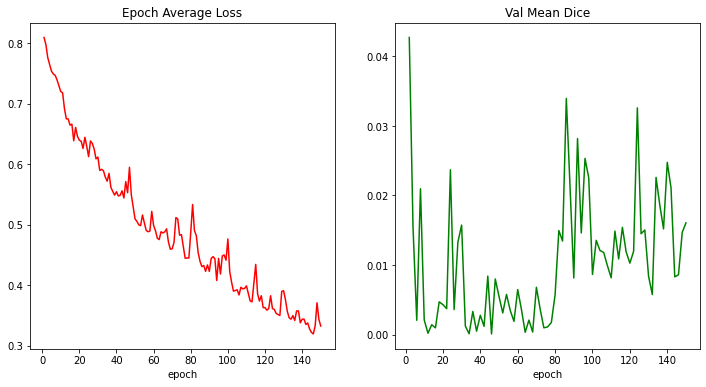

In [246]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()



In [180]:
# epochs = 3
# post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
# post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

# # start a typical PyTorch training
# val_interval = 2
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = list()
# metric_values = list()
# writer = SummaryWriter()

# for epoch in range(epochs):
    
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{10}")
   
#     model.train()
#     epoch_loss = 0
#     step = 0
    
#     for batch_data in loader:
        
#         step += 1
#         #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
#         #Swaping axes to have a batch of Batch_size, Channels, width and height
#         inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)

#         print(batch_data[0][0].shape)
#         print(inputs.shape)
        
#         optimizer.zero_grad()
        
#         #outputs = model(inputs[np.newaxis,:,:,:,:])
#         outputs = model(inputs[np.newaxis,:,:,:,:,])
        
#         loss = loss_function(outputs, labels[np.newaxis,:,:,:,:])
        
#         loss.backward()
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_len = len(loader) // loader.batch_size
        
#         print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
#         writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
    
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
#     if (epoch ) % val_interval == 0:
#         model.eval()
        
#         with torch.no_grad():
            
#             val_images = None
#             val_labels = None
#             val_outputs = None
            
#             for val_data in val_loader:
#                 val_images, val_labels = (val_data[0].to(device), val_data[1].to(device))
#                 print(val_images[0].shape)
#                 roi_size = (128, 128,-1)
#                 sw_batch_size = 1
#                 val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
#                 val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels  = [post_label(i) for i in decollate_batch(val_labels)]
#                 # compute metric for current iteration
#                 dice_metric(y_pred=val_outputs, y=val_labels)
                
                
#             # aggregate the final mean dice result
#             metric = dice_metric.aggregate().item()
#             # reset the status for next validation round
#             dice_metric.reset()
#             metric_values.append(metric)
            
#             if metric >= best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
#                 print("saved new best metric model")
#             print(
#                 "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
#                     epoch + 1, metric, best_metric, best_metric_epoch
#                 )
#             )
#             writer.add_scalar("val_mean_dice", metric, epoch + 1)

----------
epoch 1/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.9800
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.8747
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.9865
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.9427
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.9746
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.9810
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.9481
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.8700
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.9716
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9910
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.9361
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94

torch.Size([1, 256, 256, 16])
torch.Size([1, 256, 256, 16])
torch.Size([1, 256, 256, 16])
torch.Size([1, 256, 256, 16])
torch.Size([1, 256, 256, 16])
saved new best metric model
current epoch: 1 current mean dice: 0.4976 best mean dice: 0.4976 at epoch 1
----------
epoch 2/10
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.9723
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.8579
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.9835
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.9289
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.9687
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.9763
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.9319
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.8526
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9

torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
1/94, train_loss: 0.9690
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
2/94, train_loss: 0.7946
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
3/94, train_loss: 0.9773
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
4/94, train_loss: 0.9074
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
5/94, train_loss: 0.9579
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
6/94, train_loss: 0.9675
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
7/94, train_loss: 0.9138
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
8/94, train_loss: 0.7824
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
9/94, train_loss: 0.9529
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
10/94, train_loss: 0.9849
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
11/94, train_loss: 0.8935
torch.Size([1, 256, 256, 4])
torch.Size([1, 4, 256, 256])
12/94, train_loss: 0.9900
t

torch.Size([1, 256, 256, 16])
torch.Size([1, 256, 256, 16])
saved new best metric model
current epoch: 3 current mean dice: 0.4976 best mean dice: 0.4976 at epoch 3


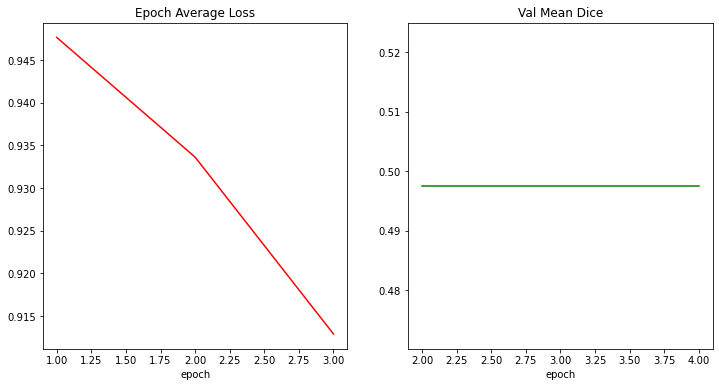

In [182]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

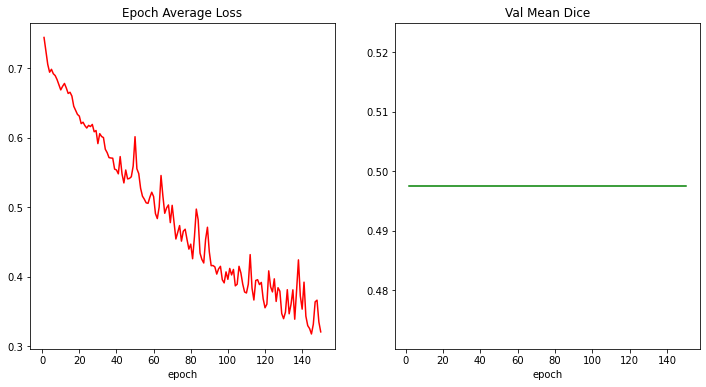

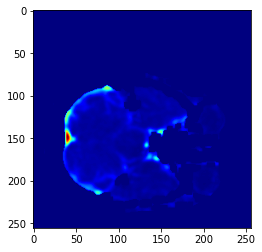

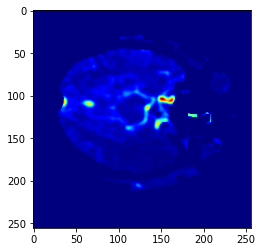

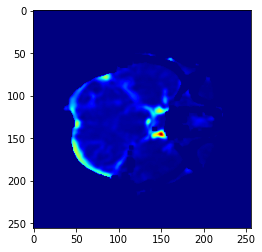

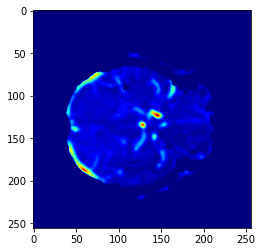

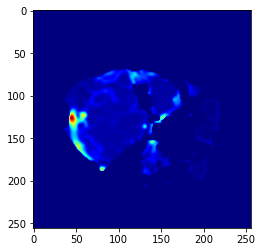

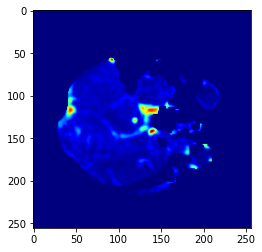

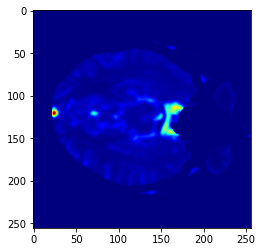

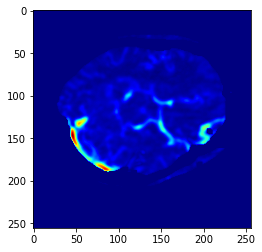

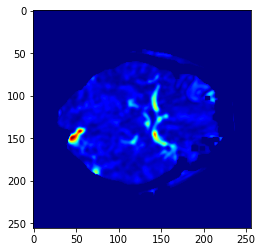

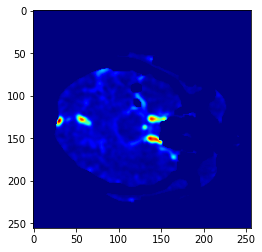

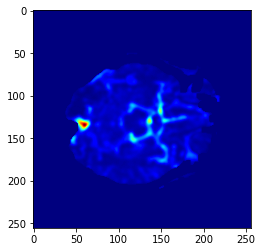

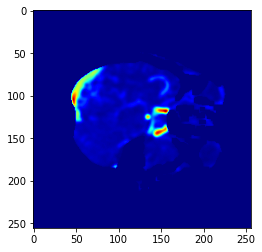

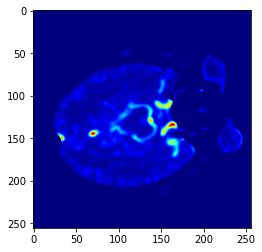

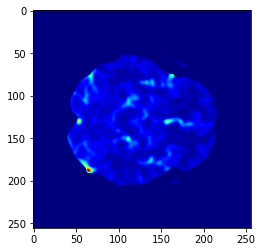

In [125]:

for val_data in val_loader:
    val_images, val_labels = val_data[0], val_data[1]
    plt.show()
    plt.imshow(val_images[0,0,:,:,5],cmap='jet')